In [1]:
import pandas as pd
from sklearn import preprocessing
from sklearn import model_selection

import evopipe
import steps
import warnings

from sklearn.model_selection import train_test_split
from sklearn import datasets
from sklearn import metrics

import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
filename = 'wilt-train.csv'

data = pd.read_csv(filename, sep=',')
train_X = data[data.columns[1:]]
train_Y = data[data.columns[0]]
le = preprocessing.LabelEncoder()

ix = train_Y.index
train_Y = pd.Series(le.fit_transform(train_Y), index=ix)


test_filename = 'wilt-test.csv'

data = pd.read_csv(test_filename, sep=',')
test_X = data[data.columns[1:]]
test_Y = data[data.columns[0]]
le = preprocessing.LabelEncoder()

ix = test_Y.index
test_Y = pd.Series(le.fit_transform(test_Y), index=ix)

params = steps.get_params(len(train_X.iloc[0]))

In [3]:
print("Format:")
print("------------")
print("Classifier")
print("score")
print("cross-validation score")
print("GridSearch score")
print("------------")
print()

with warnings.catch_warnings():
    warnings.simplefilter('ignore')
    for name, cls in steps.clfs.items():
        classif = cls()
        print(classif.__class__.__name__)
        classif.fit(train_X, train_Y)
        print(classif.score(test_X, test_Y))
        print(model_selection.cross_val_score(classif, test_X, test_Y).mean())
        
        pipe_params = params[name]
        gs = model_selection.GridSearchCV(classif, pipe_params, n_jobs=-1, verbose=5)
        gs.fit(train_X, train_Y)
        
        print(gs.best_params_)
        print(gs.score(test_X, test_Y))
        print()

Format:
------------
Classifier
score
cross-validation score
GridSearch score
------------

SVC


KeyboardInterrupt: 

In [3]:
scorer = metrics.make_scorer(metrics.cohen_kappa_score, weights='quadratic')
clf = evopipe.EvoPipeClassifier(steps.preproc, steps.clfs, params, mutpb=0.5, swap_mutpb=0.5, param_mutpb=0.7,
                                ind_mutpb=0.8, scorer=scorer)
clf.fit(train_X, train_Y, test_X, test_Y)

score = clf.score(test_X, test_Y)
print("\nBest pipeline test score: {}\n".format(score))

best_pipes = clf.best_pipelines()

for pipe, score in best_pipes:
    pipe.fit(train_X, train_Y)
    # res_Y = pipe.predict(test_X)
    
    # score = metrics.cohen_kappa_score(test_Y, res_Y, weights='quadratic')
    
    pipe_named_steps = []
    for key, val in pipe.steps:
        pipe_named_steps.append(key)       
    print("Score: {}, Pipe: {}".format(score, pipe_named_steps))

Evolution starting...

Gen 6:

Hall of fame:
[('QDA', OrderedDict([('reg_param', 0.0), ('tol', 0.01)]))]
[('kBest', OrderedDict([('k', 5)])), ('QDA', OrderedDict([('reg_param', 0.0), ('tol', 0.01)]))]
[('QDA', OrderedDict([('reg_param', 0.5), ('tol', 0.0001)]))]
[('kBest', OrderedDict([('k', 5)])), ('DT', OrderedDict([('criterion', 'entropy'), ('max_depth', 15), ('max_features', 0.1), ('min_samples_leaf', 5), ('min_samples_split', 10)]))]
[('DT', OrderedDict([('criterion', 'entropy'), ('max_depth', 15), ('max_features', 0.1), ('min_samples_leaf', 5), ('min_samples_split', 10)]))]

Gen 11:

Hall of fame:
[('kBest', OrderedDict([('k', 5)])), ('QDA', OrderedDict([('reg_param', 0.0), ('tol', 0.001)]))]
[('kBest', OrderedDict([('k', 5)])), ('QDA', OrderedDict([('reg_param', 0.1), ('tol', 0.001)]))]
[('QDA', OrderedDict([('reg_param', 0.0), ('tol', 0.0001)]))]
[('QDA', OrderedDict([('reg_param', 0.0), ('tol', 0.01)]))]
[('kBest', OrderedDict([('k', 5)])), ('QDA', OrderedDict([('reg_param', 0

   	                        fitness                         	                 train_test                 
   	--------------------------------------------------------	--------------------------------------------
gen	var        	avg     	min        	max     	var        	avg     	min  	max 
0  	0.0653467  	0.123928	-0.00275511	0.771038	0.00561873 	0.641875	0.45 	0.78
1  	0.075277   	0.366712	0          	0.771038	0.0042018  	0.706267	0.626	0.78
2  	0.0734319  	0.492751	0.010137   	0.771038	0.00391885 	0.716467	0.626	0.78
3  	0.0606422  	0.325821	0.0030299  	0.771038	0.0078828  	0.695267	0.456	0.78
4  	0.0128844  	0.734552	0.297592   	0.771038	0.000474316	0.774467	0.662	0.78
5  	4.08239e-05	0.769851	0.735444   	0.771038	3.22222e-06	0.779667	0.77 	0.78
6  	0.0705037  	0.646342	0          	0.771038	0.00270152 	0.757533	0.626	0.78
7  	0.00190812 	0.761786	0.529078   	0.771038	3.15556e-05	0.778667	0.75 	0.78
8  	1.10934e-31	0.771038	0.771038   	0.771038	8.88889e-07	0.779333	0.778	0.78
9  	0.13

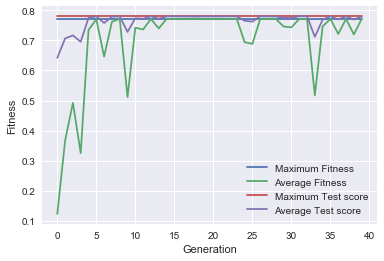

In [8]:
print(clf.logbook)

gen = clf.logbook.select("gen")
avgs, mins, maxs, vars = clf.logbook.chapters["fitness"].select("avg", "min", "max", "var")
avgs_tt, mins_tt, maxs_tt, vars_tt = clf.logbook.chapters["train_test"].select("avg", "min", "max", "var")

sns.set()

fig = plt.figure()
ax1 = fig.add_subplot(111)
line1 = ax1.plot(gen, maxs, label='Maximum Fitness')
ax1.set_xlabel("Generation")
ax1.set_ylabel("Fitness")

line2 = ax1.plot(gen, avgs, label='Average Fitness')

line3 = ax1.plot(gen, maxs_tt, label='Maximum Test score')
line4 = ax1.plot(gen, avgs_tt, label='Average Test score')

lines = line1 + line2 + line3 + line4
labels = [l.get_label() for l in lines]
ax1.legend(lines, labels, loc="best")

plt.show()